In [1]:
import numpy as np
import sys
sys.path.append('/Users/diegofiori/Desktop/epfl/master_thesis/master_thesis/')
from utils import read_pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
FILE_PATH = '/Users/diegofiori/Desktop/epfl/master_thesis/results/'
sim_code = 'cs'

In [3]:
physics_ = read_pickle(FILE_PATH+f'physical_features_end_{sim_code}.pickle')

In [4]:
physics_ = np.concatenate([physics_[i] for i in range(len(physics_))])[-100:]

In [5]:
physics_.shape

(100,)

In [6]:
density = np.exp(physics_)

In [7]:
from scipy.io import loadmat

x = loadmat(f'/Users/diegofiori/Desktop/epfl/master_thesis/k_perp_end_{sim_code}.mat')
k_perp = x['k_quantities']

In [8]:
k_perp.shape

(100, 80, 2)

In [9]:
k_perp = np.concatenate([k_perp[i, :, 0] for i in range(k_perp.shape[0])])

In [10]:
def compute_signal_processing_correlation(matrix_ts, target_ts):
    correlations = []
    for i in range(matrix_ts.shape[1]):
        correlations.append(np.correlate(matrix_ts[:, i], target_ts, 'same').reshape((-1, 1)))
        
    return np.concatenate(correlations, axis=1)

# Images Analysis

In [11]:
images_complexes = read_pickle(FILE_PATH + f'slices_top_features_end_{sim_code}.pickle')

In [12]:
selected_index = read_pickle(FILE_PATH + f'selected_index_{sim_code}.pickle')

In [13]:
selected_index

[(2, 0),
 (0, 10639),
 (0, 10185),
 (3, 11030),
 (2, 6494),
 (2, 10187),
 (2, 7),
 (3, 1),
 (1, 10385),
 (1, 4239),
 (2, 10286),
 (3, 10830),
 (3, 5),
 (1, 10485),
 (2, 3945),
 (3, 10231),
 (3, 2134),
 (0, 10717),
 (3, 10230),
 (0, 10186),
 (2, 10236),
 (2, 10699),
 (3, 10781),
 (3, 0),
 (1, 4188),
 (1, 10186),
 (3, 10881),
 (1, 10787),
 (3, 10931),
 (3, 10280),
 (2, 2088),
 (0, 10236),
 (3, 30),
 (0, 10842),
 (1, 10235),
 (2, 10639),
 (2, 21),
 (2, 6),
 (2, 10695),
 (2, 6342),
 (1, 10185),
 (3, 11131),
 (3, 9),
 (3, 7),
 (2, 4339),
 (2, 10),
 (1, 10737),
 (3, 2),
 (1, 10637),
 (1, 6),
 (3, 10330),
 (0, 10692),
 (2, 10239),
 (1, 10660),
 (2, 6440),
 (2, 10701),
 (3, 10731),
 (1, 21),
 (2, 3),
 (1, 10740),
 (0, 10638),
 (2, 10741),
 (0, 10699),
 (0, 10838),
 (1, 3),
 (2, 4287),
 (2, 2036),
 (1, 10188),
 (1, 10236),
 (3, 10730),
 (0, 10689),
 (3, 10732),
 (3, 4),
 (2, 10186),
 (3, 10681),
 (1, 10688),
 (2, 3996),
 (1, 10687),
 (2, 10188),
 (2, 4440),
 (3, 18),
 (3, 4439),
 (2, 4534),
 (2

In [14]:
images_complexes.shape

(4, 7680, 11134)

In [15]:
k_perp = k_perp[:images_complexes.shape[1]]

In [16]:
def compute_signal_processing_correlation(feature_ts, target_ts):
    return np.correlate(feature_ts, target_ts, 'same')

In [17]:
from tqdm.notebook import tqdm
correlations_series = []
for i in tqdm(range(images_complexes.shape[0])):
    for k in range(images_complexes.shape[2]):
            if (i, k) in selected_index:
                series = pd.Series(data=compute_signal_processing_correlation(images_complexes[i, :, k], k_perp),
                                   name=(i, k))
                correlations_series.append(series)

In [18]:
matrix_corr_images = pd.concat(correlations_series, axis=1)

In [19]:
matrix_corr_images.shape

(7680, 88)

In [20]:
matrix_corr_images = matrix_corr_images.loc[:, ~np.isnan(matrix_corr_images.sum(axis=0))]

In [21]:
best_positive_correlated_img_idx = matrix_corr_images.max(axis=0).argmax()
best_positive_correlated_img = matrix_corr_images.loc[:, best_positive_correlated_img_idx]
best_negative_correlated_img_idx = matrix_corr_images.min(axis=0).argmin()
best_negative_correlated_img = matrix_corr_images.loc[:, best_negative_correlated_img_idx]

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.
/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  This is separate from the ipykernel package so we can avoid doing imports until


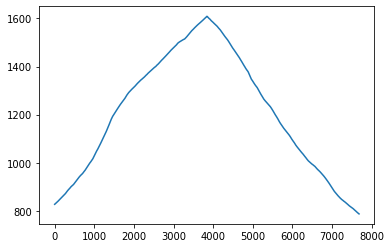

In [22]:
plt.plot(best_positive_correlated_img)

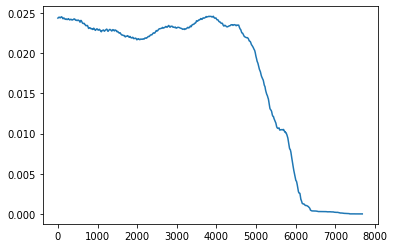

In [23]:
plt.plot(best_negative_correlated_img)

# Pearson Correlation

In [24]:
from scipy.stats import pearsonr
import pandas as pd

In [25]:
def compute_pearson_cross_correlation(x, y, tau_max):
    correlations = pd.Series(data=np.zeros((2*tau_max + 1)), index=np.arange(-tau_max, tau_max + 1))
    for i in range(-tau_max, tau_max + 1):
        if i > 0:
            new_x = x[:-i]
            new_y = y[i:]
        if i < 0:
            new_x = x[-i:]
            new_y = y[:i]
        else: 
            new_x = x
            new_y = y
        correlations[i] = pearsonr(new_x, new_y)[0]
    return correlations

Now we consider only future correlation

In [26]:
def compute_pearson_future_cross_correlation(x, y, tau_max):
    correlations = pd.Series(data=np.zeros(tau_max + 1), index=np.arange(tau_max + 1))
    for i in range(tau_max + 1):
        if i > 0:
            new_x = x[:-int(i*80)]
            new_y = y[int(i*80):]
        else: 
            new_x = x
            new_y = y
        correlations[i] = pearsonr(new_x, new_y)[0]
    return correlations

In [27]:
k_perp = k_perp[:images_complexes.shape[1]]

In [28]:
max_shift = 20
fut_correlations = []
for i in range(images_complexes.shape[0]):
        for k in range(images_complexes.shape[2]):
            if (i, k) in selected_index:
                temp = images_complexes[i, :, k]
                if np.isnan(temp.sum()):
                    temp = np.nan_to_num(temp)
                corr = compute_pearson_future_cross_correlation(temp, k_perp, max_shift)
                corr.name = (i, k)
                fut_correlations.append(corr)
fut_correlation_df = pd.concat(fut_correlations, axis=1)

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


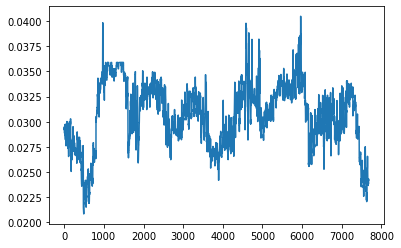

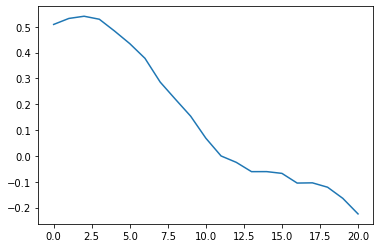

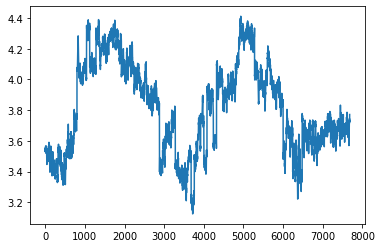

In [29]:
mcidx = fut_correlation_df.max().argmax()

plt.figure()
plt.plot(k_perp)

plt.figure()
plt.plot(fut_correlation_df[mcidx])

most_correlated = images_complexes[mcidx[0], :, mcidx[1]]
plt.figure()
plt.plot(most_correlated)

/Users/diegofiori/anaconda3/envs/giotto_env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


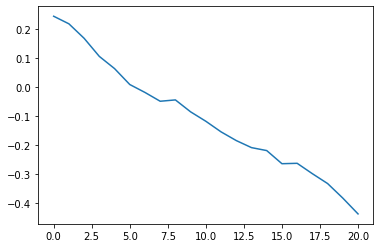

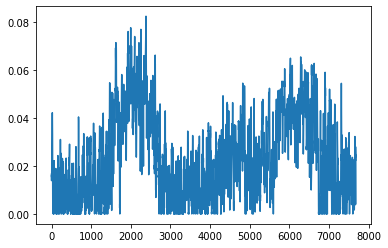

In [30]:
lcidx = fut_correlation_df.min().argmin()
less_correlated = images_complexes[lcidx[0], :, lcidx[1]]
plt.figure()
plt.plot(fut_correlation_df[lcidx])
plt.figure()
plt.plot(less_correlated)

Looking for spikes

In [31]:
max_cdidx

NameError: name 'max_cdidx' is not defined

In [ ]:
correlation_derivatives_df = fut_correlation_df.fillna(0).diff().dropna()
max_cdidx = correlation_derivatives_df.max().argmax()
plt.figure()
plt.plot(fut_correlation_df[max_cdidx])
plt.figure()
plt.plot(images_complexes[max_cdidx[0], :, max_cdidx[1]])

# Spearman correlation

In [ ]:
from scipy.stats import spearmanr

In [ ]:
def compute_spearman_future_cross_correlation(x, y, tau_max):
    correlations = pd.Series(data=np.zeros(tau_max + 1), index=np.arange(tau_max + 1))
    for i in range(tau_max + 1):
        if i > 0:
            new_x = x[:-int(i*80)]
            new_y = y[int(i*80):]
        else: 
            new_x = x
            new_y = y
        correlations[i] = spearmanr(new_x, new_y)[0]
    return correlations

In [ ]:
max_shift = 20
correlations = []
for i in range(images_complexes.shape[0]):
        for k in range(images_complexes.shape[2]):
            if (i, k) in selected_index:
                temp = images_complexes[i, :, k]
                if np.isnan(temp.sum()):
                    temp = np.nan_to_num(temp)
                corr = compute_spearman_future_cross_correlation(temp, k_perp, max_shift)
                corr.name = (i, k)
                correlations.append(corr)
correlation_df = pd.concat(correlations, axis=1)

In [ ]:
mcidx = correlation_df.max().argmax()

plt.figure()
plt.plot(k_perp)

plt.figure()
plt.plot(correlation_df[mcidx])

most_correlated = images_complexes[mcidx[0], :, mcidx[1]]
plt.figure()
plt.plot(most_correlated)

In [ ]:
lcidx = correlation_df.min().argmin()
less_correlated = images_complexes[lcidx[0], :, lcidx[1]]
plt.figure()
plt.plot(correlation_df[lcidx])
plt.figure()
plt.plot(less_correlated)

# Plot for the meeting with Paolo

In [ ]:
plt.figure()
plt.plot(density)
# plt.plot([750, 750], [0.5, 0.7], 'r')
plt.title('density')
plt.xlabel('time_steps')
plt.ylabel('density')
plt.figure()
plt.plot(k_perp)
# plt.plot([750, 750], [0, 0.2], 'r')
plt.title('k_perp')
plt.xlabel('time_steps')
plt.ylabel('k_perp')
plt.figure()
plt.plot(most_correlated)
# plt.plot([750, 750], [0, .1], 'r')
plt.title(f'topological feature {mcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')
plt.figure()
plt.plot(less_correlated)
# plt.plot([750, 750], [0, 6], 'r')
plt.title(f'topological feature {lcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')

## New data

In [ ]:
new_sim_code = 'eml'
new_density = read_pickle(FILE_PATH+f'physical_features_end_{new_sim_code}.pickle')
new_density = np.concatenate([new_density[i] for i in range(len(new_density))])[-100:]

In [ ]:
new_density.shape

In [ ]:
plt.plot(new_density)

In [ ]:
x = loadmat(f'/Users/diegofiori/Desktop/epfl/master_thesis/k_perp_end_{new_sim_code}.mat')
new_k_perp = x['k_quantities'] 

In [ ]:
new_k_perp.shape

In [ ]:
new_k_perp = np.concatenate([new_k_perp[i, :, 0] for i in range(new_k_perp.shape[0])])

In [ ]:
new_slices = read_pickle(FILE_PATH + f'slices_top_features_end_{new_sim_code}.pickle')

In [ ]:
new_slices.shape

In [ ]:
new_most_correlated = new_slices[mcidx[0], :, mcidx[1]]
new_less_correlated = new_slices[lcidx[0], :, lcidx[1]]

In [ ]:
plt.figure()
plt.plot(np.exp(new_density))
# plt.plot([750, 750], [0.5, 0.7], 'r')
plt.title('density')
plt.xlabel('time_steps')
plt.ylabel('density')
plt.figure()
plt.plot(new_k_perp)
plt.title('k_perp')
plt.xlabel('time_steps')
plt.ylabel('k_perp')
plt.figure()
plt.plot(new_most_correlated)
# plt.plot([750, 750], [0, 5], 'r')
plt.title(f'topological feature {mcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')
plt.figure()
plt.plot(new_less_correlated)
# plt.plot([750, 750], [0, 10], 'r')
plt.title(f'topological feature {lcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')

## SnowPlus

In [ ]:
new_sim_code = 'sf'
new_density = read_pickle(FILE_PATH+f'physical_features_end_{new_sim_code}.pickle')
new_density = np.concatenate([new_density[i] for i in range(len(new_density))])

x = loadmat(f'/Users/diegofiori/Desktop/epfl/master_thesis/k_perp_end_{new_sim_code}.mat')
new_k_perp = x['k_quantities'] 

new_k_perp = np.concatenate([new_k_perp[i, :, 0] for i in range(new_k_perp.shape[0])])

new_slices = read_pickle(FILE_PATH + f'slices_top_features_end_{new_sim_code}.pickle')

new_slices.shape

new_most_correlated = new_slices[mcidx[0], :, mcidx[1]]
new_less_correlated = new_slices[lcidx[0], :, lcidx[1]]

plt.figure()
plt.plot(np.exp(new_density))
# plt.plot([750, 750], [0.5, 0.7], 'r')
plt.title('density')
plt.xlabel('time_steps')
plt.ylabel('density')
plt.figure()
plt.plot(new_k_perp)
plt.title('k_perp')
plt.xlabel('time_steps')
plt.ylabel('k_perp')
plt.figure()
plt.plot(new_most_correlated)
# plt.plot([750, 750], [0, 5], 'r')
plt.title(f'topological feature {mcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')
plt.figure()
plt.plot(new_less_correlated)
# plt.plot([750, 750], [0, 10], 'r')
plt.title(f'topological feature {lcidx}')
plt.xlabel('time_steps')
plt.ylabel('top_feat')